# 프로젝트: SentencePiece 사용하기

## 회고
* 기존에는 Mecab을 사용했는데 데이터의 전처리없이 말뭉치를 바탕으로 토크나이저를 학습시켜서 사용할 수 있는 방법인 Sentencepiece에 대해 공부할 수 있었다. 
* Sentencepiece, Konlpy에서 제공하는 tokenizer인 Mecab간의 성능을 비교할 수 있었다. 

### 활용 데이터 
* 파일명: korean-english-park.train.ko
* 데이터 설명: 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터
* 출처: https://github.com/jungyeul/korean-parallel-corpora

In [ ]:
!pip install sentencepiece

In [ ]:
# library import
from konlpy.tag import *

import random 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') 

%matplotlib inline

import sentencepiece as spm

In [ ]:
SEED = 42

# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [749]:
file_path = os.getenv('HOME') +  '/aiffel/sp_tokenizer'

## 데이터 분석

### Distribution 확인

In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("** Data Size:", len(raw),'**')

print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

** Data Size: 94123 **
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


=> 코드 실행 결과
* 데이터가 총 94123개의 문장으로 이뤄져있다. 

In [4]:
# 문장 길이 확인 - 방법1
length_lst = []

for sentence in raw:
    length_lst.append(len(sentence))

raw_size = len(length_lst)
max_len = max(length_lst)
min_len = min(length_lst)

print(f'corpus 크기: {raw_size}')
print(f'문장 최소 길이: {min_len}')
print(f'문장 최장 길이: {max_len}')
print(f'문장 평균 길이: {sum(length_lst)/raw_size}')

corpus 크기: 94123
문장 최소 길이: 1
문장 최장 길이: 377
문장 평균 길이: 60.78048935966767


In [5]:
# 문장 길이 확인 - 방법2

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


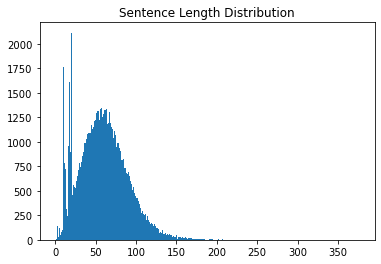

In [6]:
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [7]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            if count < 10:
                print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


=> 문장 길이가 1인 경우에 '과 같은 유의미하지 않은 문장부호가 들어가 있는 경우를 확인했다. 

In [8]:
for idx, _sum in enumerate(sentence_length):
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


=> 같은 문장 길이를 1500개 이상 가지고 있는 경우의 인덱스는 11, 19, 21임을 확인합니다.

### Noise 확인 및 정제
- Duplicated sentence
- Null data
- Delete Too short/long sentence length

In [9]:
# Delete duplicated sentence 
print("중복 데이터 제거 전 :", len(raw))

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.

print("중복 데이터 제거 후 :", len(cleaned_corpus))

중복 데이터 제거 전 : 94123
중복 데이터 제거 후 : 77591


=> 약 2만개 정도의 중복 데이터 문장들이 있었음을 알 수 있다. 

In [10]:
# Delete Null data 
print(f'Null값 제거 전: {len(cleaned_corpus)}')

for idx in range(len(cleaned_corpus)):
    # # 문장 길이 0이면 삭제 
    if len(cleaned_corpus[idx]) == 0:
        #print("Null Index:", idx+1)
        cleaned_corpus.pop(idx)
        
print(f'Null값 제거 후: {len(cleaned_corpus)}')

Null값 제거 전: 77591
Null값 제거 후: 77591


=> null값은 없다.

In [11]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 1)

’


In [12]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 2)

..
햇빛
면접
과일
6.
Q:
4.
2.
양파
3.


In [13]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 3)

프린트
단어장
통계청
▲쇼핑
둘째날
버뮤다
이벤트
교훈:
첫째날
철도청


In [14]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 4)

보조식품
(원제:
*유방암
번역 :
원문기사
5.버섯
국어사전
자유!”
사와야:
한자사전


In [15]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 5)

면접 이후
배신자!”
*산부인과
분열 조장
세부사항:
▲레스토랑
인권 침해
*심장질환
▲버스투어
해외 송금


=> 특수문장을 제외하고 의미있는 단어를 내포하고 있는지 살펴보면 길이가 2만 되어도 괜찮다는 것을 알 수 있다. 해당 모델은 tokenizer를 만들기 위함이기 때문에 짧은 문장의 데이터를 사용해도 괜찮을 것으로 생각된다. 이를 실험적으로 이후 단계에서 확인해볼 예정이다.

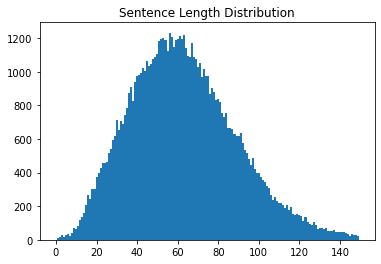

In [16]:
# 문장 길이를 기준으로 필터링
max_len = 150
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1 # length 같으면 같은 인덱스의 값을 +1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [17]:
# cleaned_corpus 데이터형 확인 
type(cleaned_corpus)

list

In [18]:
# Noise 처리 후 문장 길이 확인 & distribution 

# 문장 길이 확인
length_lst = []

for sentence in filtered_corpus:
    length_lst.append(len(sentence))

filtered_corpus_size = len(length_lst)
max_len = max(length_lst)
min_len = min(length_lst)

print(f'corpus 크기: {filtered_corpus_size}')
print(f'문장 최소 길이: {min_len}')
print(f'문장 최장 길이: {max_len}')
print(f'문장 평균 길이: {sum(length_lst)/raw_size}')

corpus 크기: 77127
문장 최소 길이: 2
문장 최장 길이: 150
문장 평균 길이: 52.3682734294487


<AxesSubplot:ylabel='count'>

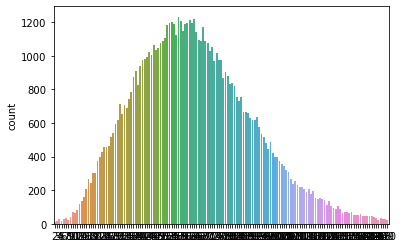

In [19]:
# Seaborn을 활용한 분포 확인
import seaborn as sns

sns.countplot(length_lst)

## Tokenization

### Sentencepiece 학습 및 테스트
* 기본적으로 <unk>, <s>, </s> 는 0, 1, 2 순으로 정의됩니다. 
    
#### 변경 가능한 파라미터 
* vocab_size: 단어사전의 크기 
* model_type: unigram과 bpe

In [20]:
len(filtered_corpus)

77127

#### vocab size=8000, model type=unigram

In [730]:
# 모델 학습
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_uni_8000 --vocab_size={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 '.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [731]:
!ls -l korean_spm_uni_*

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 376873  4월 20 23:43 korean_spm_uni_8000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 146298  4월 20 23:43 korean_spm_uni_8000.vocab


In [734]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm_uni_8000.model')

True

In [24]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1248, 12, 306, 8, 3607, 12, 285, 39, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


#### vocab size=8000, model type=bpe

In [25]:
# 모델 학습
spm.SentencePieceTrainer.Train(
    f'--input={temp_file} --model_prefix=korean_spm_bpe_8000 --vocab_size={vocab_size} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [26]:
!ls -l korean_spm_bpe*

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604885  4월 20 14:47 korean_spm_bpe_20000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336070  4월 20 14:47 korean_spm_bpe_20000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 371925  4월 20 15:10 korean_spm_bpe_8000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 117116  4월 20 15:10 korean_spm_bpe_8000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604878  4월 19 18:55 korean_spm_bpe.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336088  4월 19 18:55 korean_spm_bpe.vocab


In [27]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_8000.model')

True

In [28]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1522, 1155, 6619, 6709, 2646, 6781, 6684, 6686]
['▁아버', '지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


#### vocab size=20000, model type=bpe

In [29]:
# 모델 학습
vocab_size = 20000

spm.SentencePieceTrainer.Train(
    f'--input={temp_file} --model_prefix=korean_spm_bpe_20000 --vocab_size={vocab_size} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [30]:
!ls -l korean_spm_bpe*

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604885  4월 20 15:10 korean_spm_bpe_20000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336070  4월 20 15:10 korean_spm_bpe_20000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 371925  4월 20 15:10 korean_spm_bpe_8000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 117116  4월 20 15:10 korean_spm_bpe_8000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604878  4월 19 18:55 korean_spm_bpe.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336088  4월 19 18:55 korean_spm_bpe.vocab


In [31]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_20000.model')

True

In [32]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[7661, 6619, 18709, 2646, 18781, 18684, 18686]
['▁아버지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


## Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

### 여러 옵션으로 학습한 Tokenizer
* korean_spm_uni_8000
* korean_spm_bpe_8000
* korean_spm_bpe_20000

In [33]:
def sp_tokenize(s, corpus, max_len_): 

    tensor = []
    
#     s.SetEncodeExtraOptions('bos:eos')
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./" + s_option + ".vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen = max_len_, padding='post')

    return tensor, word_index, index_word

In [34]:
# 학습한 토크나이저 선택 
s_option = 'korean_spm_uni_8000'

s = spm.SentencePieceProcessor()
s.Load(s_option+'.model')

True

In [35]:
print(s.get_piece_size()) # vocab size

8000


In [36]:
print(s.id_to_piece(0))
print(s.id_to_piece(1))
print(s.id_to_piece(2))
print(s.id_to_piece(3))
print(s.piece_to_id('.'))

<pad>
<s>
</s>
<unk>
4


In [37]:
for id in range(4):
    print(s.id_to_piece(id), s.is_control(id))

<pad> True
<s> True
</s> True
<unk> False


In [38]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 20)
print(tensor)

[[1955 5661    6    5 7975 1985    4    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 108 1638  102    5    3  421   12    5   15    3 1972    4    4    4
     0    0    0    0    0    0]]


In [39]:
print(s.SampleEncodeAsPieces(my_corpus[0], 1, 0.0))

['▁나는', '▁밥', '을', '▁', '먹', '었습니다', '.']


In [40]:
print(s.SampleEncodeAsPieces(my_corpus[1], 1, 0.0))

['▁그러나', '▁여전', '히', '▁', 'ᅲᅲ', '▁배', '가', '▁', '고', '픕', '니다', '.', '.', '.']


In [41]:

# 문장 양 끝에 <s>, </s>를 추가 
s.SetEncodeExtraOptions('bos:eos')
print(s.SampleEncodeAsPieces(my_corpus[1], 1, 0.0))

['<s>', '▁그러나', '▁여전', '히', '▁', 'ᅲᅲ', '▁배', '가', '▁', '고', '픕', '니다', '.', '.', '.', '</s>']


In [42]:
tensor.shape

(2, 20)

## 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

### 데이터 셋팅
* 데이터불러오기
* 데이터셋 개수 확인 
* 라벨 분포 확인 

In [109]:
# 데이터 불러오기
train_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_test.txt')

In [110]:
# 데이터 개수 확인 
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 150000개
test set: 50000개


In [111]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [112]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<AxesSubplot:>

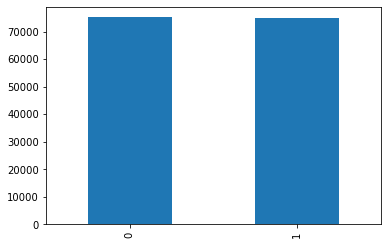

In [113]:
# label의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [114]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

### 데이터 전처리  
* 중복 제거 
* Null값 제거 
* 문장 분포 확인

#### 중복 제거

In [115]:
print(train_data['document'].value_counts())

굿                                  181
good                                92
최고                                  85
쓰레기                                 79
별로                                  66
                                  ... 
평점이 예상보다 너무 높다                       1
박시연의 외모 외엔 볼 게 없다... ㅡㅡ;;            1
ㅋㅋㅋ 이 뭥;;; ㄷㄷㄷ                       1
그렇게 실망한 영화는 처음이었다. 정성들인건 알겠지만..      1
맥라이언땜시 본 영화 -_-;                     1
Name: document, Length: 146182, dtype: int64


In [116]:
test_data['document'].value_counts()

굿                                                                                                       56
good                                                                                                    35
최고                                                                                                      30
별로                                                                                                      20
tv 전기세가 아깝다!!!                                                                                          20
                                                                                                        ..
YB가 진리임ㅎㅎ                                                                                                1
긴여운 개인적으로 너무 완벽한 영화 우리나라에서는 배두나 서울 같은 요소때문에 더 사랑받을수 있었을텐데 아쉽다                                            1
뭐이런! 스트레스 받다가 끝나네요. 절대 보지 마시길!                                                                           1
왠만해선 이런 말 안하는데... 진짜 못봐주겠다. 재미도 감동도 못

In [117]:
train_data.duplicated().sum()

0

In [118]:
test_data.duplicated().sum()

0

In [119]:
#document열을 기준으로 중복행 제거
train_data.drop_duplicates(['document'],inplace = True) #inplace = False: None 반환, True: df에 적용

In [120]:
#document열을 기준으로 중복행 제거
test_data.drop_duplicates(['document'],inplace = True) #inplace = False: None 반환, True: df에 적용

In [121]:
print(train_data['document'].value_counts())
print(test_data['document'].value_counts())

나만의 결론이 정답이 아닐지라도 너무나도 마음에드는 영화 제발 어렵다고 영화의 수준 자체를 오해하진말자 직설적인게 항상 좋은것만은 아니다, 이런 표현에 익숙지 않은게 한국인의 현실이다.    1
인류최악의 영화.내가 본 영화중 이런쓰레기영화 또첨보네                                                                             1
아진짜좋음                                                                                                      1
완전 재밌다! 나도 수목드라마 피노키오로 고정중... 것도 1화부터...                                                                   1
토나올정도로 우울하고 어두운 영화. 김기덕꺼는 남는거라도 있지.. 무료라길래 봤더니 참..                                                         1
                                                                                                          ..
지스쿼드는 상상하는 일이면서도 긴장감과 재미를 준다..넘 재밌는애니메이션니다                                                                 1
7광구가 이것보다 낫다                                                                                               1
다세포소녀와 견줄만하다. 어찌 저리 연기들을 못할까..ㅉㅉ                                                                           1
연애를 못하는 게 아니라 안하는 영

#### [오류] 
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-54-c68efab91e59> in <module>
----> 1 plt.hist([len(s) for s in list(train_data['document'])], bins=50)
      2 plt.xlabel('length of samples')
      3 plt.ylabel('number of samples')
      4 plt.show()
      5 

<ipython-input-54-c68efab91e59> in <listcomp>(.0)
----> 1 plt.hist([len(s) for s in list(train_data['document'])], bins=50)
      2 plt.xlabel('length of samples')
      3 plt.ylabel('number of samples')
      4 plt.show()
      5 

TypeError: object of type 'float' has no len()
-----
값 중간에 NaN값이 존재해서 나타나는 오류였습니다. @갓수희!
enumerate로 각 인덱스에 들어가있는 값을 확인해서 nan의 위치를 확인했습니다. 
분포 확인보다 먼저, null값을 처리해줬습니다. 

In [122]:
for i, s in enumerate(train_data['document']):
    try:
        tmp = len(s)
    except:
        print(i, "에서 오류 발생")

25521 에서 오류 발생


In [123]:
train_data['document'][25521]

'더딘 과정에 급 결말;'

#### null값 제거

In [124]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개


In [125]:
# null 개수
for col in test_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          test_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개


In [126]:
train_data.dropna(inplace = True)
test_data.dropna(inplace = True)

In [127]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [128]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

#### 데이터 분포 확인

In [129]:
train_data['document'][:10]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

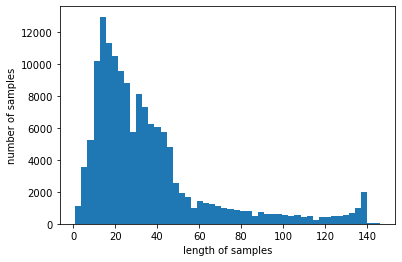

문장길이 최대 :  146
문장길이 평균 :  35.981338331668745
문장길이 최소 :  1


In [130]:
plt.hist([len(s) for s in train_data['document']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

length_lst = [len(s) for s in train_data['document']]

print('문장길이 최대 : ', max(length_lst))
print('문장길이 평균 : ', sum(length_lst)/len(length_lst))
print('문장길이 최소 : ', min(length_lst))

In [131]:
# 길이가 1인 문장 확인 
check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
굿
짱
휴
.
음
?


In [132]:
# 길이가 2인 문장 확인 
check_sentence_with_length(train_data['document'], 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오


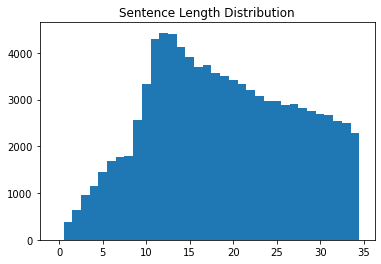

In [133]:
# 문장 길이를 기준으로 필터링
max_len = 35 # 길이 평균 
min_len = 2 # 1글자는 의미없는 경우 많음 

# 길이 조건에 맞는 문장만 선택합니다.t
train_filtered = [s for s in train_data['document'] if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_filtered:
    sentence_length[len(sen)-1] += 1 # length 같으면 같은 인덱스의 값을 +1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [134]:
len(train_filtered)

94445

In [135]:
len(train_data)

146182

In [136]:
max_len, min_len

(35, 2)

In [137]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* 특정 길이를 만족하지 못 하는 열의 값을 가진 행을 제거하고 싶을 때 
    - map 함수 사용
    - df[df[].str.len() < 특정값]
    - drop 함수 사용: df.drop(df[특정행 조건].index, inplace=True)

In [146]:
train_data = train_data[(train_data['document'].map(len) <= max_len)*(train_data['document'].map(len) >= min_len)]

In [147]:
len(train_data)

94445

In [149]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0


In [150]:
len(train_data)

94445

### Tokenizing using sentencepiece

In [175]:
X_train = []
train_word2idx = {}
train_idx2word = {}

In [228]:
max_len, min_len

(35, 2)

In [177]:
# 학습한 토크나이저 선택 
s_option = 'korean_spm_uni_8000'

s = spm.SentencePieceProcessor()
s.Load(s_option+'.model')

True

In [178]:
X_train, train_word2idx, train_idx2word = sp_tokenize(s, train_data['document'], max_len)

In [179]:
X_test = []
test_word2idx = {}
test_idx2word = {}

In [180]:
X_test, test_word2idx, test_idx2word = sp_tokenize(s, test_data['document'], max_len)

In [181]:
train_word2idx[0], train_idx2word['<s>'] # word2idx, 또는 idx2word 딕셔너리 

('<pad>', 1)

In [182]:
test_word2idx[0], test_idx2word['<s>'] # word2idx, 또는 idx2word 딕셔너리 

('<pad>', 1)

In [183]:
y_train = list(train_data['label'])
y_test = list(test_data['label'])

### 데이터셋 세팅

In [184]:
X_train.shape

(94445, 35)

In [185]:
X_test.shape

(49157, 35)

In [186]:
# validation set 29300건 분리
X_valid = X_train[:30000]   
y_valid = train_data['label'][:30000]

X_train = X_train[30000:]   
y_train = train_data['label'][30000:]

In [200]:
y_test = test_data['label']

In [187]:
len(X_valid), len(y_valid)

(30000, 30000)

In [188]:
len(X_train), len(y_train)

(64445, 64445)

###  LSTM 모델 구현

In [208]:
vocab_size = 20000
word_vector_dim = 400

In [209]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 400)         8000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 8,271,889
Trainable params: 8,271,889
Non-trainable params: 0
_________________________________________________________________


In [236]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [237]:
mc = ModelCheckpoint(file_path + "/model/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [238]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 모델 훈련

In [239]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=60, # 512, 100, 60 
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1075/1075 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9359
Epoch 00001: val_accuracy improved from -inf to 0.82040, saving model to best_model.h5
1075/1075 [==============================] - 60s 56ms/step - loss: 0.1695 - accuracy: 0.9359 - val_loss: 0.5129 - val_accuracy: 0.8204
Epoch 2/20
1074/1075 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9499
Epoch 00002: val_accuracy improved from 0.82040 to 0.82190, saving model to best_model.h5
1075/1075 [==============================] - 61s 57ms/step - loss: 0.1378 - accuracy: 0.9499 - val_loss: 0.5760 - val_accuracy: 0.8219
Epoch 3/20
1074/1075 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9566
Epoch 00003: val_accuracy did not improve from 0.82190
1075/1075 [==============================] - 59s 55ms/step - loss: 0.1201 - accuracy: 0.9566 - val_loss: 0.6166 - val_accuracy: 0.8128
Epoch 4/20
1074/1075 [============================>.] - ETA: 0s - los

### 모멜 시각화 

In [240]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


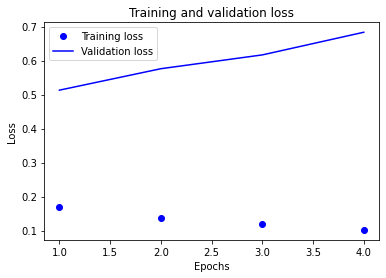

In [241]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

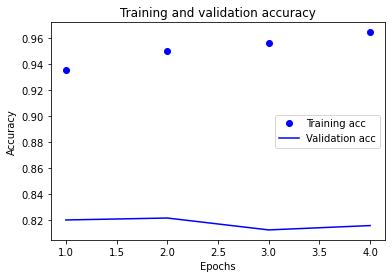

In [242]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가

In [243]:
# 최고 성능 모델 로드 
model = keras.models.load_model(file_path + "/model/best_model.h5")

In [244]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5954 - accuracy: 0.8131
[0.5953916907310486, 0.8131090402603149]


### Pooling 모델 구현 

In [245]:
model_maxpool = keras.Sequential()
model_maxpool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool.add(keras.layers.GlobalMaxPooling1D())
model_maxpool.add(keras.layers.Dense(8, activation='relu'))
model_maxpool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_maxpool.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 400)         8000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 3208      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 8,003,217
Trainable params: 8,003,217
Non-trainable params: 0
_________________________________________________________________


In [246]:
mc = ModelCheckpoint(file_path + "/model/best_model_maxpool.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [247]:
model_maxpool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [248]:
epochs = 20

maxpool_history = model_maxpool.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=60,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1075/1075 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.7915
Epoch 00001: val_accuracy improved from -inf to 0.81800, saving model to best_model_maxpool.h5
1075/1075 [==============================] - 58s 54ms/step - loss: 0.4504 - accuracy: 0.7915 - val_loss: 0.4007 - val_accuracy: 0.8180
Epoch 2/20
1075/1075 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8468
Epoch 00002: val_accuracy improved from 0.81800 to 0.82497, saving model to best_model_maxpool.h5
1075/1075 [==============================] - 58s 54ms/step - loss: 0.3507 - accuracy: 0.8468 - val_loss: 0.3950 - val_accuracy: 0.8250
Epoch 3/20
1075/1075 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8837
Epoch 00003: val_accuracy did not improve from 0.82497
1075/1075 [==============================] - 60s 55ms/step - loss: 0.2841 - accuracy: 0.8837 - val_loss: 0.4103 - val_accuracy: 0.8245
Epoch 4/20
1075/1075 [==============================]

### 모멜 시각화 

In [249]:
history_dict = maxpool_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


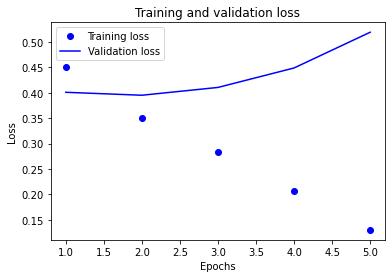

In [250]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

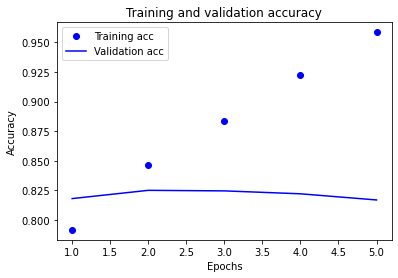

In [251]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가

In [252]:
# 최고 성능 모델 로드 
model_maxpool = keras.models.load_model(file_path + "/model/best_model_maxpool.h5")

In [253]:
# 테스트셋을 통한 모델 평가
maxpool_results = model_maxpool.evaluate(X_test,  y_test, verbose=2)
print(maxpool_results)

1537/1537 - 2s - loss: 0.4121 - accuracy: 0.8129
[0.4121212065219879, 0.8128852248191833]


## 네이버 영화리뷰 감정분석 문제에 Mecab 적용해 보기

### 데이터 셋팅
* 데이터불러오기
* 데이터셋 개수 확인 
* 라벨 분포 확인 

In [529]:
# 데이터 불러오기
train_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_test.txt')

In [530]:
# 데이터 개수 확인 
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 150000개
test set: 50000개


In [531]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [532]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<AxesSubplot:>

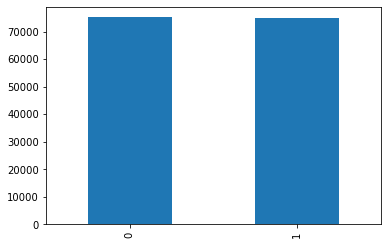

In [533]:
# label의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [534]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

### 데이터 전처리  
* 중복 제거 
* Null값 제거 
* 문장 분포 확인

#### 중복 제거

In [535]:
print(train_data['document'].value_counts())

굿                                  181
good                                92
최고                                  85
쓰레기                                 79
별로                                  66
                                  ... 
평점이 예상보다 너무 높다                       1
박시연의 외모 외엔 볼 게 없다... ㅡㅡ;;            1
ㅋㅋㅋ 이 뭥;;; ㄷㄷㄷ                       1
그렇게 실망한 영화는 처음이었다. 정성들인건 알겠지만..      1
맥라이언땜시 본 영화 -_-;                     1
Name: document, Length: 146182, dtype: int64


In [536]:
test_data['document'].value_counts()

굿                                                                                                       56
good                                                                                                    35
최고                                                                                                      30
별로                                                                                                      20
tv 전기세가 아깝다!!!                                                                                          20
                                                                                                        ..
YB가 진리임ㅎㅎ                                                                                                1
긴여운 개인적으로 너무 완벽한 영화 우리나라에서는 배두나 서울 같은 요소때문에 더 사랑받을수 있었을텐데 아쉽다                                            1
뭐이런! 스트레스 받다가 끝나네요. 절대 보지 마시길!                                                                           1
왠만해선 이런 말 안하는데... 진짜 못봐주겠다. 재미도 감동도 못

In [537]:
train_data.duplicated().sum()

0

In [538]:
test_data.duplicated().sum()

0

In [539]:
#document열을 기준으로 중복행 제거
train_data.drop_duplicates(['document'],inplace = True) #inplace = False: None 반환, True: df에 적용

In [540]:
#document열을 기준으로 중복행 제거
test_data.drop_duplicates(['document'],inplace = True) #inplace = False: None 반환, True: df에 적용

In [541]:
print(train_data['document'].value_counts())
print(test_data['document'].value_counts())

나만의 결론이 정답이 아닐지라도 너무나도 마음에드는 영화 제발 어렵다고 영화의 수준 자체를 오해하진말자 직설적인게 항상 좋은것만은 아니다, 이런 표현에 익숙지 않은게 한국인의 현실이다.    1
인류최악의 영화.내가 본 영화중 이런쓰레기영화 또첨보네                                                                             1
아진짜좋음                                                                                                      1
완전 재밌다! 나도 수목드라마 피노키오로 고정중... 것도 1화부터...                                                                   1
토나올정도로 우울하고 어두운 영화. 김기덕꺼는 남는거라도 있지.. 무료라길래 봤더니 참..                                                         1
                                                                                                          ..
지스쿼드는 상상하는 일이면서도 긴장감과 재미를 준다..넘 재밌는애니메이션니다                                                                 1
7광구가 이것보다 낫다                                                                                               1
다세포소녀와 견줄만하다. 어찌 저리 연기들을 못할까..ㅉㅉ                                                                           1
연애를 못하는 게 아니라 안하는 영

#### [오류] 
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-54-c68efab91e59> in <module>
----> 1 plt.hist([len(s) for s in list(train_data['document'])], bins=50)
      2 plt.xlabel('length of samples')
      3 plt.ylabel('number of samples')
      4 plt.show()
      5 

<ipython-input-54-c68efab91e59> in <listcomp>(.0)
----> 1 plt.hist([len(s) for s in list(train_data['document'])], bins=50)
      2 plt.xlabel('length of samples')
      3 plt.ylabel('number of samples')
      4 plt.show()
      5 

TypeError: object of type 'float' has no len()
-----
값 중간에 NaN값이 존재해서 나타나는 오류였습니다. @갓수희!
enumerate로 각 인덱스에 들어가있는 값을 확인해서 nan의 위치를 확인했습니다. 
분포 확인보다 먼저, null값을 처리해줬습니다. 

In [542]:
for i, s in enumerate(train_data['document']):
    try:
        tmp = len(s)
    except:
        print(i, "에서 오류 발생")

25521 에서 오류 발생


In [543]:
train_data['document'][25521]

'더딘 과정에 급 결말;'

#### null값 제거

In [544]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개


In [545]:
# null 개수
for col in test_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          test_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개


In [546]:
train_data.dropna(inplace = True)
test_data.dropna(inplace = True)

In [547]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [548]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

#### 데이터 분포 확인

In [549]:
train_data['document'][:10]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

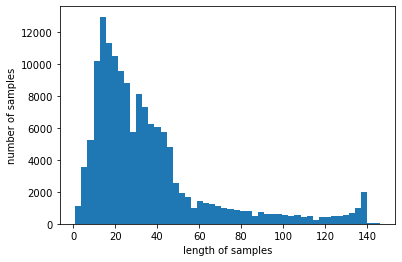

문장길이 최대 :  146
문장길이 평균 :  35.981338331668745
문장길이 최소 :  1


In [550]:
plt.hist([len(s) for s in train_data['document']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

length_lst = [len(s) for s in train_data['document']]

print('문장길이 최대 : ', max(length_lst))
print('문장길이 평균 : ', sum(length_lst)/len(length_lst))
print('문장길이 최소 : ', min(length_lst))

In [551]:
# 길이가 1인 문장 확인 
check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
굿
짱
휴
.
음
?


In [552]:
# 길이가 2인 문장 확인 
check_sentence_with_length(train_data['document'], 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오


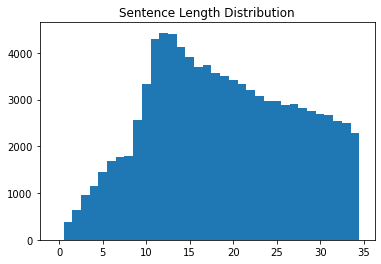

In [553]:
# 문장 길이를 기준으로 필터링
max_len = 35 # 길이 평균 
min_len = 2 # 1글자는 의미없는 경우 많음 

# 길이 조건에 맞는 문장만 선택합니다.t
train_filtered = [s for s in train_data['document'] if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_filtered:
    sentence_length[len(sen)-1] += 1 # length 같으면 같은 인덱스의 값을 +1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [554]:
len(train_filtered)

94445

In [555]:
len(train_data)

146182

In [556]:
max_len, min_len

(35, 2)

* 특정 길이를 만족하지 못 하는 열의 값을 가진 행을 제거하고 싶을 때 
    - map 함수 사용
    - df[df[].str.len() < 특정값]
    - drop 함수 사용: df.drop(df[특정행 조건].index, inplace=True)

In [557]:
train_data = train_data[(train_data['document'].map(len) <= max_len)*(train_data['document'].map(len) >= min_len)]

In [558]:
len(train_data)

94445

In [559]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0


In [560]:
# 특수문자 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0


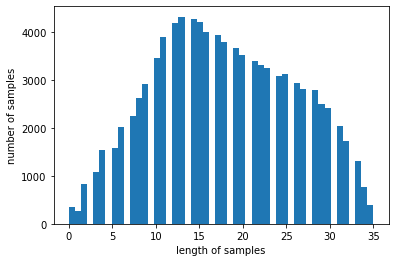

문장길이 최대 :  35
문장길이 평균 :  17.84664090211234
문장길이 최소 :  0


In [561]:
plt.hist([len(s) for s in train_data['document']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

length_lst = [len(s) for s in train_data['document']]

print('문장길이 최대 : ', max(length_lst))
print('문장길이 평균 : ', sum(length_lst)/len(length_lst))
print('문장길이 최소 : ', min(length_lst))

### Tokenizing using Mecab

In [562]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도', '를','으로','자','에','와','한','하다','을','에서','해서']

In [642]:
X_train = []
X_test = []

In [643]:
for sentence in train_data['document']:
    X_tmp = []
    X_tmp = tokenizer.morphs(sentence) # 토큰화 
    X_tmp = [word for word in X_tmp if not word in stopwords] #불용어 제거 
    X_train.append(X_tmp)

In [644]:
X_train[:3]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

In [645]:
# 4초 정도 소요
for sentence in test_data['document']:
    X_tmp = []
    X_tmp = tokenizer.morphs(sentence) # 토큰화 
    X_tmp = [word for word in X_tmp if not word in stopwords] #불용어 제거 
    X_test.append(X_tmp)

In [646]:
X_test[:3]

[['굳', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐',
  '야',
  '평점',
  '.',
  '...',
  '나쁘',
  '진',
  '않',
  '지만',
  '10',
  '점',
  '짜리',
  '더더욱',
  '아니',
  '잖아']]

In [647]:
len(X_train), len(X_test)

(94445, 49157)

In [648]:
words = np.concatenate(X_train).tolist()
len(words)

712344

In [649]:
vocab_size

8000

In [650]:
vocab_size = 8000

In [651]:
from collections import Counter

counter = Counter(words)
counter = counter.most_common(vocab_size-4)
vocab = ['<pad>', '<s>', '</s>', '<unk>'] + [key for key, _ in counter] # 빈도수 상위 vocab size만큼만 가져오기 

word_to_index = {word:index for index, word in enumerate(vocab)}

In [652]:
type(word_to_index), len(word_to_index)

(dict, 8000)

In [653]:
word_to_index['<pad>']

0

In [654]:
word_to_index['<s>']

1

In [655]:
word_to_index['</s>']

2

In [656]:
word_to_index['<unk>']

3

In [657]:
len(word_to_index) # vocab_size만큼 index가 만들어져 있다. 

8000

In [658]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in wordlist]

In [659]:
wordlist_to_indexlist(['웨웽', '얄어러야']) # 모르는 단어는 unk 토큰으로 

[3, 3]

In [660]:
wordlist_to_indexlist(['짜증', '재미없']) # 있는 단어는 해당하는 토큰 index 반환 

[217, 61]

In [661]:
wordlist_to_indexlist(X_train[0])

[25, 71, 915, 27, 217, 16, 30, 822]

In [662]:
[0] + [0, 1, 2] + [3]

[0, 0, 1, 2, 3]

In [663]:
# 한 문장을 넣었을 때 띄어쓰기 기준으로 토큰화해준 후, index로 반환해주는 함수 
def get_encoded_sentence(sentence):
    return [word_to_index['<s>']]+[word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence.split()]+[word_to_index['<s>']]

In [664]:
get_encoded_sentence('아 짜증난다')

[1, 25, 3, 1]

In [665]:
# 토큰화 완료된 문장에 대해서 진행할때
def get_sentence_indexlist(sentence):
    return [word_to_index['<s>']]+[word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]+[word_to_index['</s>']]

In [666]:
get_sentence_indexlist(['우왕', '굳', '짱'])

[1, 2017, 417, 121, 2]

In [667]:
X_train = list(map(get_sentence_indexlist, X_train))

In [668]:
X_train[:3]

[[1, 25, 71, 915, 27, 217, 16, 30, 822, 2],
 [1, 667, 394, 490, 539, 4, 123, 1435, 55, 984, 768, 10, 42, 273, 2],
 [1, 15, 109, 3, 2]]

In [669]:
X_test = list(map(get_sentence_indexlist, X_test))

In [672]:
X_test[:3]

[[1, 417, 95, 2],
 [1, 3, 2],
 [1, 66, 88, 35, 3, 3, 880, 289, 42, 40, 3, 26, 529, 3566, 79, 632, 2]]

In [673]:
y_train = list(train_data['label'])
y_test = list(test_data['label'])

### 데이터셋 세팅

In [674]:
len(X_train), len(y_train)

(94445, 94445)

In [675]:
len(X_train[0])

10

In [676]:
len(X_test), len(y_test)

(49157, 49157)

In [677]:
max_len 

35

In [682]:
# 불용어가 제거되기 때문에 기존 max_len보다 더 적을 수 있음 
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in X_train]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_len = np.max(num_tokens)  # max_len 업데이트

문장길이 평균 :  9.542421515167558
문장길이 최대 :  26
문장길이 표준편차 :  3.4562362844657653


In [679]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in X_test]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  17.656935939947516
문장길이 최대 :  107
문장길이 표준편차 :  12.611989590010854


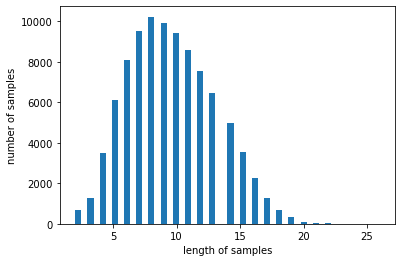

In [680]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [683]:
max_len

26

In [686]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, 
                        maxlen = max_len,
                        value=word_to_index["<pad>"],
                        padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                       maxlen = max_len,
                       value=word_to_index["<pad>"],
                       padding='post')

In [713]:
print(X_train.shape)
print(X_test.shape)

(64445, 26)
(49157, 26)


In [700]:
# validation set 30000 분리
X_valid = X_train[:30000]   
y_valid = train_data['label'][:30000]

X_train = X_train[30000:]   
y_train = train_data['label'][30000:]

In [715]:
print(y_valid.shape)
print(y_train.shape)

(30000,)
(64445,)


In [716]:
y_test = test_data['label']

###  LSTM 모델 구현

In [701]:
vocab_size = 20000
word_vector_dim = 400

In [702]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 400)         8000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 8,271,889
Trainable params: 8,271,889
Non-trainable params: 0
_________________________________________________________________


In [703]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [704]:
mc = ModelCheckpoint(file_path + "/model/mecab_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [705]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 모델 훈련

In [706]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=60, # 512, 100, 60 
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1075/1075 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5008
Epoch 00001: val_accuracy improved from -inf to 0.50150, saving model to mecab_best_model.h5
1075/1075 [==============================] - 58s 54ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 2/20
1074/1075 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5001
Epoch 00002: val_accuracy did not improve from 0.50150
1075/1075 [==============================] - 56s 52ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 3/20
1075/1075 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4969
Epoch 00003: val_accuracy did not improve from 0.50150
1075/1075 [==============================] - 59s 54ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/20
1075/1075 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4999


### 모멜 시각화 

In [707]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


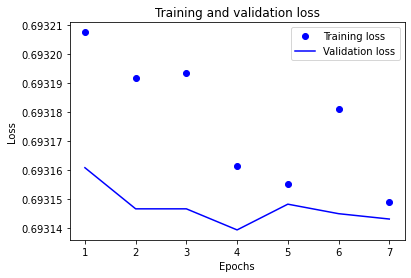

In [708]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

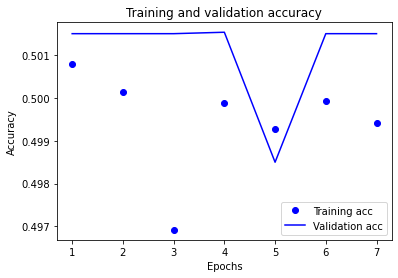

In [709]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가

In [710]:
# 최고 성능 모델 로드 
model = keras.models.load_model(file_path + "/model/mecab_best_model.h5")

In [717]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.6928 - accuracy: 0.5238
[0.6927785873413086, 0.5237504243850708]


### Pooling 모델 구현 

In [718]:
model_maxpool = keras.Sequential()
model_maxpool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool.add(keras.layers.GlobalMaxPooling1D())
model_maxpool.add(keras.layers.Dense(8, activation='relu'))
model_maxpool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_maxpool.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 400)         8000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 3208      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 8,003,217
Trainable params: 8,003,217
Non-trainable params: 0
_________________________________________________________________


In [736]:
mc = ModelCheckpoint(file_path + "/model/mecab_best_model_maxpool.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [737]:
model_maxpool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [738]:
epochs = 20

maxpool_history = model_maxpool.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=60,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1074/1075 [============================>.] - ETA: 0s - loss: 0.2579 - accuracy: 0.8961
Epoch 00001: val_accuracy improved from -inf to 0.83727, saving model to /model/mecab_best_model_maxpool.h5
1075/1075 [==============================] - 61s 57ms/step - loss: 0.2579 - accuracy: 0.8961 - val_loss: 0.3883 - val_accuracy: 0.8373
Epoch 2/20
1075/1075 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9217
Epoch 00002: val_accuracy did not improve from 0.83727
1075/1075 [==============================] - 61s 57ms/step - loss: 0.2046 - accuracy: 0.9217 - val_loss: 0.4387 - val_accuracy: 0.8332
Epoch 3/20
1075/1075 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9496
Epoch 00003: val_accuracy did not improve from 0.83727
1075/1075 [==============================] - 62s 58ms/step - loss: 0.1453 - accuracy: 0.9496 - val_loss: 0.5088 - val_accuracy: 0.8289
Epoch 4/20
1075/1075 [==============================] - ETA: 0s - loss: 0.0944 - ac

### 모멜 시각화 

In [739]:
history_dict = maxpool_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


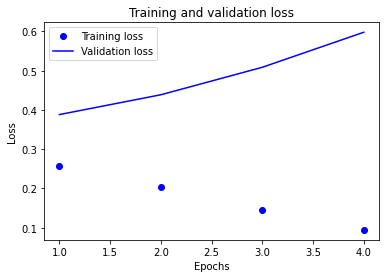

In [740]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

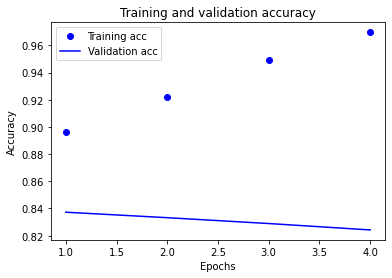

In [741]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가

In [750]:
# 최고 성능 모델 로드 
model_maxpool = keras.models.load_model(file_path + "/model/mecab_best_model_maxpool.h5")

In [751]:
# 테스트셋을 통한 모델 평가
maxpool_results = model_maxpool.evaluate(X_test,  y_test, verbose=2)
print(maxpool_results)

1537/1537 - 2s - loss: 0.3806 - accuracy: 0.8308
[0.38059332966804504, 0.8308480978012085]


---

## 결과 비교
GMP 모델과 Mecab tokenizer을 사용했을 때 가장 성능이 좋았습니다. 
그러나, 실행시간을 비교해보면 Tokenizing을 할 때 Sentencepiece의 경우가 훨씬 빠르게 진행되었습니다. 

|model|vocab_size|tokenizer|loss   |accuracy|
|-----|----------|---------|-------|--------|
|LSTM|20000|Sentencepiece/vocab=8000/model_type=unigram|0.5954|0.8131|
|GMP|20000|Sentencepiece/vocab=8000/model_type=unigram|0.4121|0.8129|
|LSTM|20000|Mecab/vocab=8000|0.6928|0.5238|
|GMP|20000|Mecab/vocab=8000|0.3806|0.8308|